In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import git
import sys
import os
import time
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

repo = git.Repo('.', search_parent_directories=True)
BASE_DIR = repo.working_tree_dir
sys.path.append(BASE_DIR)

import model.datasets.argoverse.dataset as dataset
import model.datasets.argoverse.dataset_utils as dataset_utils 
import model.datasets.argoverse.map_functions as map_functions

# Set root_dir to the correct path to your dataset folder

split_name = "train"
root_dir = os.path.join(BASE_DIR,f'data/datasets/argoverse/motion-forecasting/{split_name}/')

In [27]:
relevant_centerlines_filtered = np.load(root_dir+"data_processed_1_percent/relevant_centerlines.npz",allow_pickle=True)

In [43]:
relevant_centerlines_filtered['arr_0'].item()['1']['real_world_width']

66.42676238059357

In [10]:
files, num_files = dataset_utils.load_list_from_folder(root_dir+"data")

file_id_list = []
root_file_name = None
for file_name in files:
    if not root_file_name:
        root_file_name = os.path.dirname(os.path.abspath(file_name))
    file_id = int(os.path.normpath(file_name).split('/')[-1].split('.')[0])
    file_id_list.append(file_id)
file_id_list.sort()
print("Num files: ", num_files)

Num files:  205942


In [20]:
debug_centerlines = [27353, 57791, 102781, 129915, 143124, 146034, 149913, 154633, 160433, 166298, 168101, 189296, 209572]

debug_indeces = []

for debug_centerline_id in debug_centerlines:
    index = file_id_list.index(debug_centerline_id)
    debug_indeces.append(index)

print("debug_indeces: ", debug_indeces)

debug_indeces:  [26613, 56236, 100007, 126363, 139208, 142045, 145818, 150399, 156057, 161756, 163502, 184151, 203875]


In [29]:
test_centerlines = []
i = j = 0
for file_index in range(len(file_id_list)):
    if file_index in debug_indeces:
        test_centerlines.append(debug_relevant_centerlines[j])
        j += 1
    else:
        test_centerlines.append(unfinished_relevant_centerlines[i])
        i += 1

test_centerlines = np.array(test_centerlines)
test_centerlines.shape

(205942, 40, 2)

In [28]:
from model.datasets.argoverse.map_functions import MapFeaturesUtils
map_features_utils_instance = MapFeaturesUtils()

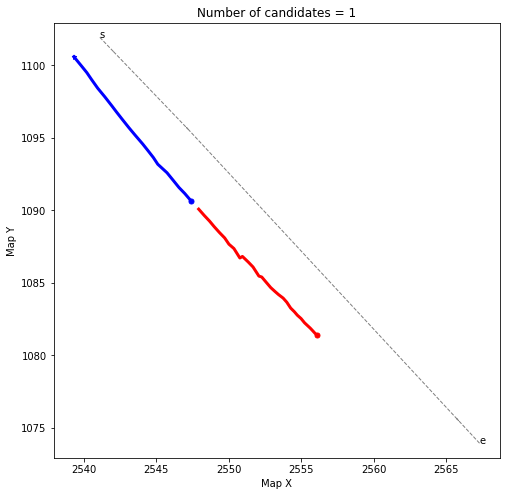

In [32]:
file_id = 160433

obs_len = 20
pred_len = 30

seq_path = os.path.join(root_dir+"data",str(file_id)+".csv")

start = time.time()

# Compute map features using Argoverse Forecasting Baseline algorithm

start = time.time()

df = pd.read_csv(seq_path, dtype={"TIMESTAMP": str})

# Get social and map features for the agent

RAW_DATA_FORMAT = {
    "TIMESTAMP": 0,
    "TRACK_ID": 1,
    "OBJECT_TYPE": 2,
    "X": 3,
    "Y": 4,
    "CITY_NAME": 5,
}

agent_track = df[df["OBJECT_TYPE"] == "AGENT"].values
city_name = agent_track[0,RAW_DATA_FORMAT["CITY_NAME"]]
agent_xy = agent_track[:,[RAW_DATA_FORMAT["X"],RAW_DATA_FORMAT["Y"]]].astype("float")
map_features_utils_instance.debug_centerline_and_agent([test_centerlines[file_id_list.index(file_id),:,:]], 
                                                       agent_xy, obs_len, obs_len+pred_len, split_name, file_id)

In [33]:
test_centerlines.shape

(205942, 40, 2)

In [35]:
filename = root_dir+"data_processed_100_percent/relevant_centerlines.npy"
with open(filename, 'wb') as my_file: np.save(my_file, test_centerlines)

In [37]:
relevant_centerlines = np.load(filename)
relevant_centerlines.shape

(205942, 40, 2)